In [1]:
import numpy as np
from functools import partial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import seaborn as sns
import scipy.linalg 
from typing import Callable

import KF_Library as kf

# Model parameters

In [2]:
l = 4
T = 100*l 
t1 = np.arange(T)
A = np.array([[0.8499, 0.0350, 0.0240, 0.0431],
              [1.2081, 0.0738, 0.0763, 0.4087],
              [0.7331, 0.0674, 0.0878, 0.8767],
              [0.0172, 0.0047, 0.0114, 0.9123]])

B = np.array([[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1]])
Q = np.eye(4)
R = np.eye(2)


nx = np.shape(Q)[0]
ny = np.shape(R)[0]
q = np.random.multivariate_normal(np.zeros(nx), Q, T)
r = np.random.multivariate_normal(np.zeros(ny), R,  T//l)


# Initialization

In [3]:
x_init = np.array([0., 0., 0., 0.])
cov_init = np.diag([1., 1., 1., 1.])

# Model simulation

In [4]:
x = np.zeros((T,nx))
h = np.zeros((T//l,nx))
y = np.zeros((T//l,ny))
# x[0] = x_init
x_model = x_init
for i in range(T):
    x_model = A @ x_model + q[i-1]
    x[i] = x_model #A @ x[i-1] + q[i-1]
    if i%l == 0:
#         print(x[i-l+1:i+1, :])
        h[i//l ] = 1/l * np.sum(x[i-l+1:i+1, :], axis=0)
        y[i//l ] = C @ h[i//l ] + r[i//l ]


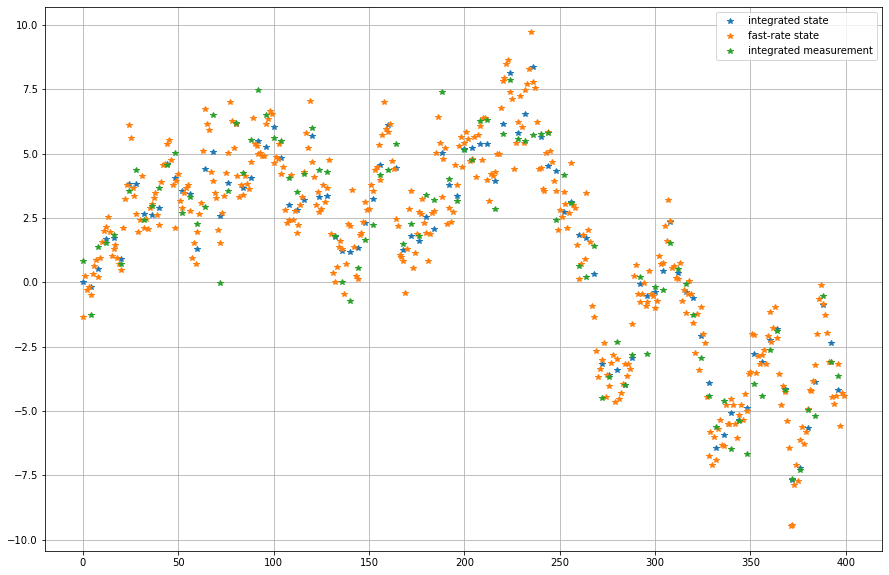

In [5]:
plt.figure(figsize = (15,10))

plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(T),x[:,0],'*',label = 'fast-rate state')
plt.plot(np.arange(0,T,l),y[:,0],'*',label = 'integrated measurement')
plt.legend()
plt.grid()

# Model simulation for Kalman Filter ($l$=1)

In [6]:
# steps = 100
# m0 = x_init  # Suitable initial mean
# P0 = cov_init # Suitable initial covariance

# LQ = linalg.cholesky(Q, lower=True)
# L0 = linalg.cholesky(P0, lower=True)

# T1 = np.zeros((steps,))
# X = np.zeros((steps,4))
# Y = np.zeros((steps,2))

# x_kf_test = m0 #+ L0 @ np.random.normal(size=(m0.shape))
# X[0,:] = x_init
# t = 0

# for n in range(1,steps):
# #     q = LQ @ np.random.normal(size=x_kf_test.shape)
#     xt_ = A @ X[n-1,:] + q[n-1]
# #     r = np.random.normal()
#     y = C @ xt_ + r[n]
#     t = t + 0.1
#     T1[n] = t
#     X[n,:] = xt_
#     Y[n,:] = y

# plt.clf()
# plt.plot(T1,X[:,0],T1,Y[:,0],'.',T1,X[:,1],':')
# plt.legend(['p','y','dp/dt'])

# IMKF

In [7]:
x_hat = np.zeros((T,x_init.shape[0]))
x_hat[0] = x_init
Px = np.zeros((T,x_init.shape[0],x_init.shape[0]))
Px[0] = cov_init
h_hat = np.zeros((T//l,x_init.shape[0]))
Ph = np.zeros((T//l,x_init.shape[0],x_init.shape[0]))

A_bar = 0*A
for i in range(1,l+1):
    A_bar += 1/l * np.linalg.matrix_power(A, i)
M = np.zeros((l,A.shape[0], A.shape[1]))
for i in range(l):
    for j in range(l-i):
        M[i] += 1/l * np.linalg.matrix_power(A, j)
Q_M = 0*Q
for i in range(l):
    Q_M +=  M[i]@Q@M[i].T   

In [8]:
inverse = lambda a: np.linalg.solve(a, np.eye(a.shape[0]))
for t in range(l,T,l):
    
    # prediction
    h_hat_ = A_bar @ x_hat[t-l]
    P_h_   = A_bar @ Px[t-l] @ A_bar.T + Q_M
    
    #Update
    L = P_h_.T @ C.T @ inverse(C @ P_h_ @ C.T + R)
    h_hat[t//l] = h_hat_ + L @ (y[t//l] - C @ h_hat_)
    Ph[t//l] = P_h_ - L @ C @ P_h_

    #Smoothing
    for i in range(1,l+1):
        At = np.linalg.matrix_power(A, i) @ inverse(A_bar)
        x_hat[t-l+i] = At @ h_hat[t//l]
        C_bar = At @ L @ C 
        Qx1 = 0*Q
        Qx2 = 0*Q
        for j in range(1,i+1):
            Qx1 += (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)) @ Q @ (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)).T
        for j in range(i+1, l+1):
            Qx2 += C_bar @ M[j-1] @ Q @ (C_bar @ M[j-1]).T
        Qx3 = (At - C_bar) @ Q_M @ (At - C_bar).T

        Qx = Qx1 + Qx2 - Qx3
        Px[t-l+i] = At @ Ph[t//l] @ At.T + Qx
        

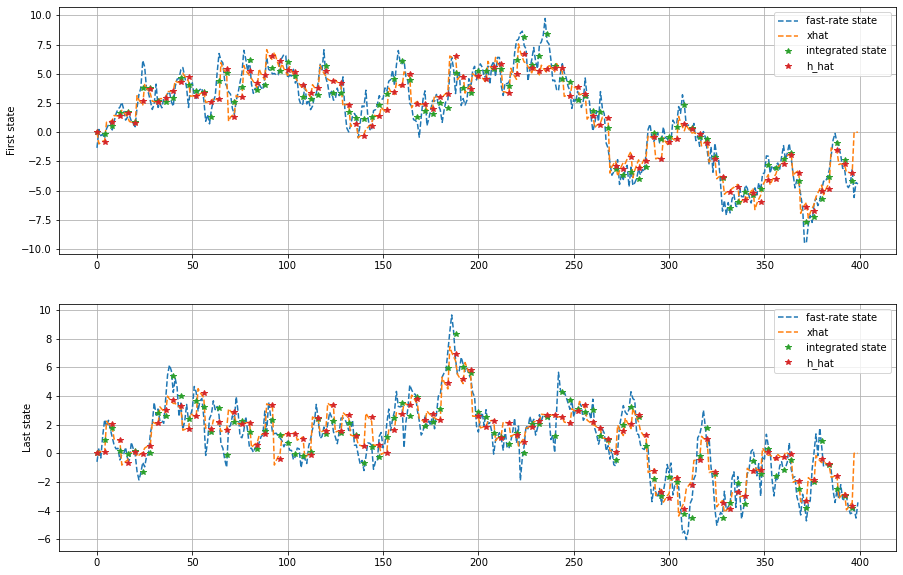

In [9]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(x[:,0],'--',label = 'fast-rate state')
plt.plot(x_hat[:,0],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,0],'*',label = 'h_hat')
plt.ylabel('First state')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x[:,3],'--',label = 'fast-rate state')
plt.plot(x_hat[:,3],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,3],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,3],'*',label = 'h_hat')
plt.ylabel('Last state')
plt.legend()
plt.grid()

# Kalman Filter

m = x_init
P = cov_init
kf_m = np.zeros((T, m.shape[0]))
kf_P = np.zeros((T, P.shape[0], P.shape[1]))
kf_m[0] = x_init
kf_P[0] = cov_init
for n in range(1,T):
    # Prediction
    m = A @ m
    P = A @ P @ A.T + Q
    # Update
    S = C @ P @ C.T + R
    K = P @ C.T @ linalg.inv(S)
    m = m + K @ (y[n] - C @ m)
    P = P - K @ S @ K.T
    kf_m[n,:] = m
    kf_P[n,:,:] = P

# Parallel integrated state estimation

In [10]:
#filtering
a = kf.filteringInitializer(A_bar, Q_M, C, R, y, x_init, cov_init, T,l)
kf_res = kf.parallelScanAlgorithm(a, T, kf.filtering)

KF_m = []
KF_P = []
for k in range(l,len(kf_res),l): 
    KF_m.append(kf_res[k]['b'])
    KF_P.append(kf_res[k]['C'])
kf_m_par = np.array(KF_m).reshape(-1,4)

Kshape= (4, 2)
m1shape= (4,)
mm (2,)


In [15]:
kf_res[8]['b']

array([[1.17429402],
       [2.27624671],
       [2.65712152],
       [2.060692  ]])

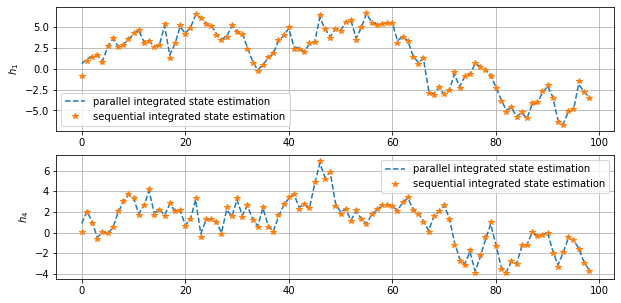

In [12]:

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.plot(kf_m_par[:,0],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,0], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_1$')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(kf_m_par[:,3],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,3], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_4$')
plt.legend()
plt.grid()

In [18]:
h_hat[:,0]

array([ 0.        , -0.83309443,  0.9161767 ,  1.39857557,  1.60221145,
        0.83060175,  2.68482797,  3.67787852,  2.60589829,  2.89490687,
        3.50967275,  4.28044075,  4.68635965,  3.08568661,  3.3289034 ,
        2.55279617,  2.81456054,  5.37664052,  1.30818112,  3.01616885,
        5.2227832 ,  4.19944264,  4.91062523,  6.55933026,  6.08545716,
        5.31830027,  5.12679445,  4.04372376,  3.384035  ,  3.82454582,
        5.21783765,  4.41976551,  4.18254577,  2.34433818,  0.66974207,
       -0.30699004,  0.50163681,  1.38409796,  1.8887392 ,  3.45702891,
        4.0261661 ,  4.94683749,  2.40901777,  2.38911881,  2.01009735,
        3.04565042,  3.24715364,  6.48423548,  4.72284405,  3.72824866,
        4.78533077,  4.5668591 ,  5.58990748,  5.80096231,  3.39076763,
        4.95297959,  6.71112657,  5.48613074,  5.23933878,  5.38367823,
        5.4704115 ,  5.50306086,  3.07082875,  3.85019781,  3.26925103,
        1.36166186,  0.61632628,  1.2564035 , -2.90178634, -3.12

In [19]:
kf_m_par[:,0]

array([ 0.58839704,  1.17429402,  1.42219146,  1.60138283,  0.92621329,
        2.55233717,  3.5675759 ,  2.6874962 ,  2.8871842 ,  3.44066704,
        4.1806404 ,  4.62743082,  3.24140325,  3.35258284,  2.61602256,
        2.82614072,  5.15302   ,  1.63458224,  2.94686728,  5.0098927 ,
        4.2504431 ,  4.89775206,  6.42840555,  6.10485148,  5.45893256,
        5.213739  ,  4.19630743,  3.51730484,  3.85568246,  5.10060198,
        4.48153637,  4.22408972,  2.54821558,  0.87893794, -0.15081039,
        0.47209585,  1.27165896,  1.82263829,  3.31146984,  3.93328273,
        4.83481151,  2.60753633,  2.43996004,  2.06517784,  2.96184857,
        3.2042542 ,  6.14725495,  4.75770255,  3.82772708,  4.70410748,
        4.59401578,  5.53353883,  5.79006324,  3.64555199,  4.89787958,
        6.56649673,  5.59883139,  5.31960369,  5.41381726,  5.48805101,
        5.52540671,  3.32007898,  3.86513094,  3.32634716,  1.54747715,
        0.74050891,  1.23127825, -2.52741704, -3.01036078, -2.23